# Spectral normalization GAN with categorical projection conditioning
*Thomas Viehmann <tv@lernapparat.de>*

# This is work in progress, i.e. it probably doesn't work

Spectral Normalization GANs are an exiting new regularization method that approximates the Wasserstein loss as a discriminator function. The authors also demonstrated the capabilities of a projection method for the discriminator - generating images for all 1000 imagenet (LSVRC2012) categories. We implement the smaller 64x64 pixel variant.
One of the crucial ingredients on the side of the Generator is a Conditional Batch Norm that enables learning a class-specific multiplier and bias.

This repository
- is a straightforward adaptation of the [official chainer-based implementation in the 64x64 case](https://github.com/pfnet-research/sngan_projection)
- PyTorch's [spectral_norm](https://pytorch.org/docs/master/nn.html#torch.nn.utils.spectral_norm) implementation
- a custom Conditional Batch Norm modelled after the above official implementation but in a PyTorch-style way (see below)
- Python 3 and PyTorch / master + [PR 9020](https://github.com/pytorch/pytorch/pull/9020)

First let's import something:

In [34]:
import torch
import torch.utils.data
import torchvision
import os
import matplotlib

try: # We want to have headless support after converting to .py
    %matplotlib inline
except:
    matplotlib.use('Agg')
from matplotlib import pyplot

import time

## Conditional Batch Norm

Here is the promised conditional batch norm. It aims to be compatible in functionality [to the SN-GAN author's version](https://github.com/pfnet-research/sngan_projection), the original reference seems to be [de Vries et. al., Modulating early visual processing by language](https://arxiv.org/abs/1707.00683).

It works pretty much like [regular batch norm](https://pytorch.org/docs/master/nn.html#torch.nn.BatchNorm2d) *except* that it has a per-class weight $\gamma$ and bias $\beta$.
In particular, note that the input mean and variance (to be "cleaned") and the running statistics are *not* class dependent. (Of course, one might wonder whether it should, but that is for another day...)

There also is a conditional instance norm, (which would resolve the input that the statistics being generated accross classes during training, but not during evaluation).

In [35]:
class BatchNorm2d(torch.nn.BatchNorm2d):
    def reset_parameters(self):
        self.reset_running_stats()
        if self.affine:
            self.weight.data.fill_(1.0)
            self.bias.data.zero_()

class CategoricalConditionalBatchNorm(torch.nn.Module):
    # as in the chainer SN-GAN implementation , we keep per-cat XXX.
    # I should care more about accreal
    def __init__(self, num_features, num_cats, eps=1e-5, momentum=0.1, affine=True,
                 track_running_stats=True):
        super().__init__()
        self.num_features = num_features
        self.num_cats = num_cats
        self.eps = eps
        self.momentum = momentum
        self.affine = affine
        self.track_running_stats = track_running_stats
        if self.affine:
            self.weight = torch.nn.Parameter(torch.Tensor(num_cats, num_features))
            self.bias = torch.nn.Parameter(torch.Tensor(num_cats, num_features))
        else:
            self.rsegister_parameter('weight', None)
            self.register_parameter('bias', None)
        if self.track_running_stats:
            self.register_buffer('running_mean', torch.zeros(num_features))
            self.register_buffer('running_var', torch.ones(num_features))
            self.register_buffer('num_batches_tracked', torch.tensor(0, dtype=torch.long))
        else:
            self.register_parameter('running_mean', None)
            self.register_parameter('running_var', None)
            self.register_parameter('num_batches_tracked', None)
        self.reset_parameters()

    def reset_running_stats(self):
        if self.track_running_stats:
            self.running_mean.zero_()
            self.running_var.fill_(1)
            self.num_batches_tracked.zero_()

    def reset_parameters(self):
        self.reset_running_stats()
        if self.affine:
            self.weight.data.fill_(1.0)
            self.bias.data.zero_()

    def _check_input_dim(self, input):
        raise NotImplementedError

    def forward(self, input, cats):
        #self._check_input_dim(input)

        exponential_average_factor = 0.0

        if self.training and self.track_running_stats:
            self.num_batches_tracked += 1
            if self.momentum is None:  # use cumulative moving average
                exponential_average_factor = 1.0 / self.num_batches_tracked.item()
            else:  # use exponential moving average
                exponential_average_factor = self.momentum

        n = input.size(0)
        numel_per_feature = input.numel()/input.size(1)
        if self.training or not self.track_running_stats:
            with torch.no_grad():
                m = input
                for d in range(input.dim()):
                    if d != 1:
                        m = m.mean(d, keepdim=True)
                v = (input-m).pow_(2)
                for d in range(input.dim()):
                    if d != 1:
                        v = v.mean(d, keepdim=True)
                unbiased_var_update = (v * (numel_per_feature / (numel_per_feature - 1.0))).squeeze_().mul_(exponential_average_factor)

                if self.track_running_stats:
                    self.running_var *= (1 - exponential_average_factor)
                    self.running_var += unbiased_var_update
                    self.running_mean *= (1 - exponential_average_factor)
                    self.running_mean += exponential_average_factor * m.squeeze()
        else:
            shape = [1, -1] + (input.dim() - 2) * [1]
            v = self.running_var.detach().view(shape)
            m = self.running_mean.detach().view(shape)
            

        x = (input - m) / (v + self.eps).sqrt_()
        
        if self.affine:
            shape = [n, -1] + (input.dim() - 2) * [1]
            weight = self.weight.index_select(0, cats).view(shape)
            bias = self.bias.index_select(0, cats).view(shape)
            x = x * weight + bias
        return x

    def extra_repr(self):
        return '{num_features}, num_cats={num_cats}, eps={eps}, momentum={momentum}, affine={affine}, ' \
               'track_running_stats={track_running_stats}'.format(**self.__dict__)



## Generator

With that, we can define the generator.

In [36]:

class ResGenBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels=None, ksize=3, pad=1,
                 activation=torch.nn.functional.relu, upsample=False, n_classes=0):
        super().__init__()
        self.activation = activation
        self.upsample = upsample
        self.learnable_sc = in_channels != out_channels or upsample
        hidden_channels = out_channels if hidden_channels is None else hidden_channels
        self.n_classes = n_classes
        self.c1 = torch.nn.Conv2d(in_channels, hidden_channels, ksize, padding=pad)
        torch.nn.init.xavier_uniform_(self.c1.weight, gain=(2**0.5))
        torch.nn.init.zeros_(self.c1.bias)
        self.c2 = torch.nn.Conv2d(hidden_channels, out_channels, ksize, padding=pad)
        torch.nn.init.xavier_uniform_(self.c2.weight, gain=(2**0.5))
        torch.nn.init.zeros_(self.c2.bias)
        if n_classes > 0:
            self.b1 = CategoricalConditionalBatchNorm(in_channels, n_classes)
            self.b2 = CategoricalConditionalBatchNorm(hidden_channels, n_classes)
        else:
            self.b1 = BatchNorm2d(in_channels)
            self.b2 = BatchNorm2d(hidden_channels)
        if self.learnable_sc:
            self.c_sc = torch.nn.Conv2d(in_channels, out_channels, 1, padding=0)
            torch.nn.init.xavier_uniform_(self.c_sc.weight)
            torch.nn.init.zeros_(self.c_sc.bias)

    def forward(self, x, y=None, DEBUG=None, debugname="ResGenBlock"):
        h = x
        if DEBUG is not None: DEBUG[debugname+'.inp'] = h.detach().cpu()
        h = self.b1(h, y) if y is not None else self.b1(h)
        if DEBUG is not None: DEBUG[debugname+'.b1'] = h.detach().cpu()
        h = self.activation(h)
        if DEBUG is not None: DEBUG[debugname+'.a1'] = h.detach().cpu()
        if self.upsample:
            h = torch.nn.functional.upsample(h, scale_factor=2)
        h = self.c1(h)
        if DEBUG is not None: DEBUG[debugname+'.c1'] = h.detach().cpu()
        h = self.b2(h, y) if y is not None else self.b2(h)
        if DEBUG is not None: DEBUG[debugname+'.b2'] = h.detach().cpu()
        h = self.activation(h)
        if DEBUG is not None: DEBUG[debugname+'.a2'] = h.detach().cpu()
        h = self.c2(h)
        if DEBUG is not None: DEBUG[debugname+'.c2'] = h.detach().cpu()
        if self.learnable_sc:
            if self.upsample:
                x = torch.nn.functional.upsample(x, scale_factor=2)
            sc = self.c_sc(x)
            if DEBUG is not None: DEBUG[debugname+'.sc'] = h.detach().cpu()
        else:
            sc = x
        return h + sc


class ResNetGenerator(torch.nn.Module):
    def __init__(self, ch=64, dim_z=128, bottom_width=4, activation=torch.nn.functional.relu, n_classes=0, distribution="normal"):
        super().__init__()
        self.bottom_width = bottom_width
        self.activation = activation
        self.distribution = distribution
        self.dim_z = dim_z
        self.n_classes = n_classes
        self.l1 = torch.nn.Linear(dim_z, (bottom_width ** 2) * ch * 16)
        torch.nn.init.xavier_uniform_(self.l1.weight)
        torch.nn.init.zeros_(self.l1.bias)
        self.block2 = ResGenBlock(ch * 16, ch * 8, activation=activation, upsample=True, n_classes=n_classes)
        self.block3 = ResGenBlock(ch * 8, ch * 4, activation=activation, upsample=True, n_classes=n_classes)
        self.block4 = ResGenBlock(ch * 4, ch * 2, activation=activation, upsample=True, n_classes=n_classes)
        self.block5 = ResGenBlock(ch * 2, ch, activation=activation, upsample=True, n_classes=n_classes)
        self.b6 = BatchNorm2d(ch)
        self.l6 = torch.nn.Conv2d(ch, 3, 3, stride=1, padding=1)
        torch.nn.init.xavier_uniform_(self.l6.weight)
        torch.nn.init.zeros_(self.l6.bias)

    def forward(self, batchsize=64, z=None, y=None, DEBUG=None, debugname="generator"):
        anyparam = next(self.parameters())
        if z is None:
            z = torch.randn(batchsize, self.dim_z, dtype=anyparam.dtype, device=anyparam.device)
        if y is None and self.n_classes > 0:
            y = torch.randint(0, self.n_classes, (batchsize,), device=anyparam.device, dtype=torch.long)
        if (y is not None) and z.shape[0] != y.shape[0]:
            raise Exception('z.shape[0] != y.shape[0], z.shape[0]={}, y.shape[0]={}'.format(z.shape[0], y.shape[0]))
        if DEBUG is not None: DEBUG[debugname+'.y'] = y.detach().cpu()
        if DEBUG is not None: DEBUG[debugname+'.z'] = z.detach().cpu()
        h = z
        h = self.l1(h)
        if DEBUG is not None: DEBUG[debugname+'.l1'] = h.detach().cpu()
        h = h.reshape(h.shape[0], -1, self.bottom_width, self.bottom_width)
        if DEBUG is not None: DEBUG[debugname+'.l1r'] = h.detach().cpu()
        h = self.block2(h, y, DEBUG=DEBUG, debugname=debugname+'.block2')
        if DEBUG is not None: DEBUG[debugname+'.block2'] = h.detach().cpu()
        h = self.block3(h, y, DEBUG=DEBUG, debugname=debugname+'.block3')
        if DEBUG is not None: DEBUG[debugname+'.block3'] = h.detach().cpu()
        h = self.block4(h, y, DEBUG=DEBUG, debugname=debugname+'.block4')
        if DEBUG is not None: DEBUG[debugname+'.block4'] = h.detach().cpu()
        h = self.block5(h, y, DEBUG=DEBUG, debugname=debugname+'.block5')
        if DEBUG is not None: DEBUG[debugname+'.block5'] = h.detach().cpu()
        h = self.b6(h)
        if DEBUG is not None: DEBUG[debugname+'.b6'] = h.detach().cpu()
        h = self.activation(h)
        h = torch.tanh(self.l6(h))
        if DEBUG is not None: DEBUG[debugname+'.l6'] = h.detach().cpu()
        return h


## Discriminator

And the discriminator. So one of the subtle differences between ResDisBlock and the ResDisOptimizedBlock is that ResDisBlock starts with an activation - even though these look like they could be both covered by a single module...

In [37]:
class ResDisBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels=None, ksize=3, pad=1,
                 activation=torch.nn.functional.relu, downsample=False):
        super().__init__()
        self.activation = activation
        self.downsample = downsample
        self.learnable_sc = (in_channels != out_channels) or downsample
        hidden_channels = in_channels if hidden_channels is None else hidden_channels
        self.c1 = torch.nn.Conv2d(in_channels, hidden_channels, ksize, padding=pad)
        torch.nn.init.xavier_uniform_(self.c1.weight, gain=(2**0.5))
        torch.nn.init.zeros_(self.c1.bias)
        torch.nn.utils.spectral_norm(self.c1)
        self.c2 = torch.nn.Conv2d(hidden_channels, out_channels, ksize, padding=pad)
        torch.nn.init.xavier_uniform_(self.c2.weight, gain=(2**0.5))
        torch.nn.init.zeros_(self.c2.bias)
        torch.nn.utils.spectral_norm(self.c2)
        if self.learnable_sc:
            self.c_sc = torch.nn.Conv2d(in_channels, out_channels, 1, padding=0)
            torch.nn.init.xavier_uniform_(self.c_sc.weight)
            torch.nn.init.zeros_(self.c_sc.bias)
            torch.nn.utils.spectral_norm(self.c_sc)

    def forward(self, x, DEBUG=None, debugname="ResDisBlock"):
        h = x
        if DEBUG is not None: DEBUG[debugname+'.inp'] = h.detach().cpu()
        h = self.activation(h)
        if DEBUG is not None: DEBUG[debugname+'.a1'] = h.detach().cpu()
        h = self.c1(h)
        if DEBUG is not None: DEBUG[debugname+'.c1'] = h.detach().cpu()
        h = self.activation(h)
        if DEBUG is not None: DEBUG[debugname+'.a2'] = h.detach().cpu()
        h = self.c2(h)
        if DEBUG is not None: DEBUG[debugname+'.c2'] = h.detach().cpu()
        if self.downsample:
            h = torch.nn.functional.avg_pool2d(h, 2)
            if DEBUG is not None: DEBUG[debugname+'.dn'] = h.detach().cpu()
        if self.learnable_sc:
            sc = self.c_sc(x)
            if DEBUG is not None: DEBUG[debugname+'.sc'] = h.detach().cpu()
            if self.downsample:
                sc = torch.nn.functional.avg_pool2d(sc, 2)
                if DEBUG is not None: DEBUG[debugname+'.scdn'] = h.detach().cpu()
        else:
            sc = x
        return h + sc

class ResDisOptimizedBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, ksize=3, pad=1, activation=torch.nn.functional.relu):
        super().__init__()
        self.activation = activation
        self.c1 = torch.nn.Conv2d(in_channels, out_channels, ksize, padding=pad)
        torch.nn.init.xavier_uniform_(self.c1.weight, gain=(2**0.5))
        torch.nn.init.zeros_(self.c1.bias)
        torch.nn.utils.spectral_norm(self.c1)
        self.c2 = torch.nn.Conv2d(out_channels, out_channels, ksize, padding=pad)
        torch.nn.init.xavier_uniform_(self.c2.weight, gain=(2**0.5))
        torch.nn.init.zeros_(self.c2.bias)
        torch.nn.utils.spectral_norm(self.c2)
        self.c_sc = torch.nn.Conv2d(in_channels, out_channels, 1, padding=0)
        torch.nn.init.xavier_uniform_(self.c_sc.weight)
        torch.nn.init.zeros_(self.c_sc.bias)
        torch.nn.utils.spectral_norm(self.c_sc)

    def forward(self, x, DEBUG=None, debugname="ResDisOptBlock"):
        h = x
        if DEBUG is not None: DEBUG[debugname+'.inp'] = h.detach().cpu()
        h = self.c1(h)
        if DEBUG is not None: DEBUG[debugname+'.c1'] = h.detach().cpu()
        h = self.activation(h)
        if DEBUG is not None: DEBUG[debugname+'.a1'] = h.detach().cpu()
        h = self.c2(h)
        if DEBUG is not None: DEBUG[debugname+'.c2'] = h.detach().cpu()
        h = torch.nn.functional.avg_pool2d(h, 2)
        if DEBUG is not None: DEBUG[debugname+'.dn'] = h.detach().cpu()
        sc = self.c_sc(x)
        if DEBUG is not None: DEBUG[debugname+'.sc'] = h.detach().cpu()
        sc = torch.nn.functional.avg_pool2d(sc, 2)
        if DEBUG is not None: DEBUG[debugname+'.scdn'] = h.detach().cpu()
        return h + sc

class SNResNetProjectionDiscriminator(torch.nn.Module):
    def __init__(self, ch=64, n_classes=0, activation=torch.nn.functional.relu):
        super().__init__()
        self.activation = activation
        self.block1 = ResDisOptimizedBlock(3, ch)
        self.block2 = ResDisBlock(ch, ch * 2, activation=activation, downsample=True)
        self.block3 = ResDisBlock(ch * 2, ch * 4, activation=activation, downsample=True)
        self.block4 = ResDisBlock(ch * 4, ch * 8, activation=activation, downsample=True)
        self.block5 = ResDisBlock(ch * 8, ch * 16, activation=activation, downsample=True)
        self.l6 = torch.nn.Linear(ch * 16, 1)
        torch.nn.init.xavier_uniform_(self.l6.weight)
        torch.nn.init.zeros_(self.l6.bias)
        torch.nn.utils.spectral_norm(self.l6)

        if n_classes > 0:
            self.l_y = torch.nn.Embedding(n_classes, ch * 16)
            torch.nn.init.xavier_uniform_(self.l_y.weight)
            #torch.nn.init.zeros_(self.l_y.bias)
            torch.nn.utils.spectral_norm(self.l_y)

    def forward(self, x, y=None, DEBUG=None, debugname="discriminator"):
        h = x
        if DEBUG is not None: DEBUG[debugname+'.inp'] = h.detach().cpu()
        h = self.block1(h, DEBUG=DEBUG, debugname=debugname+'.block1')
        if DEBUG is not None: DEBUG[debugname+'.block1'] = h.detach().cpu()
        h = self.block2(h, DEBUG=DEBUG, debugname=debugname+'.block2')
        if DEBUG is not None: DEBUG[debugname+'.block2'] = h.detach().cpu()
        h = self.block3(h, DEBUG=DEBUG, debugname=debugname+'.block3')
        if DEBUG is not None: DEBUG[debugname+'.block3'] = h.detach().cpu()
        h = self.block4(h, DEBUG=DEBUG, debugname=debugname+'.block4')
        if DEBUG is not None: DEBUG[debugname+'.block4'] = h.detach().cpu()
        h = self.block5(h, DEBUG=DEBUG, debugname=debugname+'.block5')
        if DEBUG is not None: DEBUG[debugname+'.block5'] = h.detach().cpu()
        h = self.activation(h)
        if DEBUG is not None: DEBUG[debugname+'.a1'] = h.detach().cpu()
        h = h.sum([2, 3])
        if DEBUG is not None: DEBUG[debugname+'.pool'] = h.detach().cpu()
        output = self.l6(h)
        if DEBUG is not None: DEBUG[debugname+'.l6'] = output.detach().cpu()
        if y is not None:
            w_y = self.l_y(y)
            if DEBUG is not None: DEBUG[debugname+'.w_y'] = w_y.detach().cpu()
            output = output + (w_y * h).sum(dim=1, keepdim=True)
            if DEBUG is not None: DEBUG[debugname+'.output'] = output.detach().cpu()
        return output


## Putting it together

Let's have some hyperparameters.

In [38]:
batchsize = 64
num_iterations = 250000
iterations_decay_start = 200000
seed = 0
display_interval = 20
snapshot_interval = 10000
evaluation_interval = 1000
init_lr = 0.0002
num_discriminator_iter = 5
num_classes = 143 # cats and dogs
device = torch.device('cuda')

DATADIR = '/home/datasets/imagenet/'
traindir = os.path.join(DATADIR, 'train')
valdir = os.path.join(DATADIR, 'val')

traindir = '/home/tv/data/vision/other-sn-gan/sngan_projection/datasets/preprocessed_cats_dogs/'


## Dataloader

We use the imagenet dataloader from `torchvision`. We resize to 64x64. (I'm not sure whether the original implementation does some cropping).

In [39]:
normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225])

# replicates chainer preprocessing with size 64, augmentation=false
transforms = torchvision.transforms.Compose([torchvision.transforms.Resize(256),
                                     torchvision.transforms.CenterCrop(256),
                                     torchvision.transforms.Resize(64),
                                     torchvision.transforms.ToTensor(),
                                     torchvision.transforms.Lambda(lambda x: x*(255./128.)-1+torch.rand(*x.shape)/128.)])

# tries to replicate chainer preprocessing with size 64 augmentation=true
# tries to replicate chainer preprocessing with size 64, augmentation=true
transforms = torchvision.transforms.Compose([torchvision.transforms.Resize(256),
                                     torchvision.transforms.RandomCrop(int(256*0.9)),
                                     torchvision.transforms.Resize(64),
                                     torchvision.transforms.RandomHorizontalFlip(),
                                     torchvision.transforms.ToTensor(),
                                     torchvision.transforms.Lambda(lambda x: x*(255./128.)-1+torch.rand(*x.shape)/128.)])

train_dataset = torchvision.datasets.ImageFolder(traindir, transforms)

#val_dataset = torchvision.datasets.ImageFolder(valdir, transforms)



In [59]:
generator = ResNetGenerator(dim_z=128, bottom_width=4, ch=64, n_classes=num_classes)
discriminator = SNResNetProjectionDiscriminator(ch=64, n_classes=num_classes)
generator.to(device)
discriminator.to(device)


SNResNetProjectionDiscriminator(
  (block1): ResDisOptimizedBlock(
    (c1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c_sc): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
  )
  (block2): ResDisBlock(
    (c1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c_sc): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
  )
  (block3): ResDisBlock(
    (c1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c_sc): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  )
  (block4): ResDisBlock(
    (c1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c2): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (c_sc): Conv2d(256, 512, kernel_size=(

In [15]:
def endless_train_dl(dl):
    while True:
        for b in dl:
            yield b

opt_dis = torch.optim.Adam(params=discriminator.parameters(), lr=init_lr, betas=(0.0, 0.9))
opt_gen = torch.optim.Adam(params=generator.parameters(), lr=init_lr, betas=(0.0, 0.9))
train_dl_ = torch.utils.data.DataLoader(train_dataset, batch_size=batchsize, shuffle=True, pin_memory=True, num_workers=4)
train_dl = endless_train_dl(train_dl_)


## Chicken!

(if you are using the full imagenet)

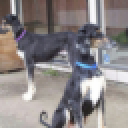

In [74]:
img = None
if matplotlib.get_backend().lower() != 'agg':
    im, lab = train_dataset[11000]
    img = torchvision.transforms.functional.to_pil_image(im*0.5+0.5)
    img = img.resize((128,128))
img

## Training

Training promises to take 60 hours on my computer.

In [ ]:
time1 = time.time()
for it_nr in range(num_iterations):
    opt_dis.param_groups[0]['lr'] = init_lr * (1 - max(it_nr - iterations_decay_start, 0) / (num_iterations - iterations_decay_start))
    opt_gen.param_groups[0]['lr'] = init_lr * (1 - max(it_nr - iterations_decay_start, 0) / (num_iterations - iterations_decay_start))
    for i in range(num_discriminator_iter):
        if i == 0:
            #discriminator.eval() # ?
            for p in discriminator.parameters():
                p.requires_grad = False
            #generator.train()
            for p in generator.parameters():
                p.requires_grad = True
            # generator step batch size could be made different from batch size
            y_fake = torch.randint(0, generator.n_classes, (batchsize,), device=device, dtype=torch.long)
            x_fake = generator(batchsize, y=y_fake)
            dis_fake = discriminator(x_fake, y=y_fake)
            loss_gen = -dis_fake.mean()
            opt_gen.zero_grad()
            loss_gen.backward()
            opt_gen.step()

        #discriminator.train() # ?
        for p in discriminator.parameters():
            p.requires_grad = True
        #generator.eval()
        for p in generator.parameters():
            p.requires_grad = False

        x_real, y_real = next(train_dl)
        x_real = x_real.to(device)
        y_real = y_real.to(device)
        bs = len(x_real)
        dis_real = discriminator(x_real, y=y_real)
        with torch.no_grad():
            y_fake = torch.randint(0, generator.n_classes, (bs,), device=device, dtype=torch.long)
            x_fake = generator(bs, y=y_fake).detach()
        dis_fake = discriminator(x_fake, y=y_fake)

        loss_dis = (torch.nn.functional.relu(1. - dis_real).mean() +
                    torch.nn.functional.relu(1. + dis_fake).mean())
        opt_dis.zero_grad()
        loss_dis.backward()
        opt_dis.step()
    if it_nr % display_interval == 0:
        print('loss_gen', loss_gen.item())
        print('it_nr',it_nr, 'i', i, 'loss_dis', loss_dis.item())
        time2 = time.time()
        print ("it_nr", it_nr, "/", num_iterations, time2 - time1)
        remaining = int((time2 - time1)* (num_iterations - it_nr) / float(display_interval))
        print ("remaining {:02d}:{:02d}:{:02d}".format(remaining // 3600, remaining // 60 % 60, remaining % 60))
        time1 = time2
    if it_nr % evaluation_interval == 0:
        with torch.no_grad():
            y_fake = torch.randint(0, generator.n_classes, (batchsize,), device=device, dtype=torch.long)
            x_fake = generator(batchsize, y=y_fake)
            img = torchvision.transforms.functional.to_pil_image((x_fake.view(8,8,3,64,64).permute(2,0,3,1,4).reshape(3, 8*64,8*64)*0.5+0.5).cpu())
            img.save(f"sample_{it_nr}.jpg")
    if it_nr % snapshot_interval == 0:
        print ("saving snapshot")
        torch.save([discriminator.state_dict(), generator.state_dict()], f"snapshot_{it_nr}.pt")
print ("saving snapshot")
torch.save([discriminator.state_dict(), generator.state_dict()], f"snapshot_{it_nr}.pt")


In [350]:
if matplotlib.get_backend().lower() == 'agg': # below is not for non-interactive
    import sys
    sys.exit(0)

# Sampling


In [71]:
generator = ResNetGenerator(dim_z=128, bottom_width=4, ch=64, n_classes=num_classes)
discriminator = SNResNetProjectionDiscriminator(ch=64, n_classes=num_classes)


[dis_sd, gen_sd] = torch.load('./snapshot_0.pt')
discriminator.load_state_dict(dis_sd)
generator.load_state_dict(gen_sd)

In [72]:
y_fake = torch.randint(0, generator.n_classes, (batchsize,), device=next(generator.parameters()).device, dtype=torch.long)
x_fake = generator(batchsize, y=y_fake)

img = torchvision.transforms.functional.to_pil_image((x_fake.view(8,8,3,64,64).permute(2,0,3,1,4).reshape(3, 8*64,8*64)*0.5+0.5).cpu())

img.save("sample_manual.jpg")

# Random stuff for debugging

Stuff like comparison to original chainer implementation, loading their weights etc.

In [293]:
generator = ResNetGenerator(n_classes=143)
generator.eval()
import numpy
sd = numpy.load('/home/tv/data/paper-implementations/sngan_projection/pretrained/ResNetGeneratorImageNet_250000.npz')
k0 = sorted(sd.keys())
k2=sorted(generator.state_dict().keys())
k1 = [((k+'$').replace('/','.').replace('.beta','.bias').replace('.gamma','.weight')
           .replace('.avg_mean','.running_mean').replace('.avg_var','.running_var')
           .replace('.N$','.num_batches_tracked$').replace('.weights.W$','.weight$')
           .replace('.biass.W$','.bias$').replace('.W$','.weight$').replace('.b$','.bias$')
          [:-1],k) for k in k0]
sd2 = {k:torch.from_numpy(sd[kold]) for k,kold in k1}
generator.load_state_dict(sd2)


In [ ]:
def rename_param(k):
    return ((k+'$').replace('/','.').replace('.beta','.bias').replace('.gamma','.weight')
                   .replace('.avg_mean','.running_mean').replace('.avg_var','.running_var')
                   .replace('.N$','.num_batches_tracked$').replace('.weights.W$','.weight$')
                   .replace('.biass.W$','.bias$').replace('.W$','.weight$').replace('.b$','.bias$')
                    .replace('.u$', '.weight_u$')[:-1])

discriminator = SNResNetProjectionDiscriminator(n_classes=143)
#discriminator.eval()
import numpy
sd = numpy.load('/home/tv/data/paper-implementations/sngan_projection/pretrained/ResNetGeneratorImageNet_250000.npz.DISC')
k0 = sorted(sd.keys())
k2=sorted(generator.state_dict().keys())
k1 = [((k+'$').replace('/','.').replace('.beta','.bias').replace('.gamma','.weight')
           .replace('.avg_mean','.running_mean').replace('.avg_var','.running_var')
           .replace('.N$','.num_batches_tracked$').replace('.weights.W$','.weight$')
           .replace('.biass.W$','.bias$').replace('.W$','.weight$').replace('.b$','.bias$')
           .replace('.u$', '.weight_u$')
          [:-1],k) for k in k0]
sd2 = {k:torch.from_numpy(sd[kold]) for k,kold in k1}
sdo = discriminator.state_dict()
for k in [k for k in sdo.keys() if k.endswith('_orig')]:
    sd2[k] = sd2[k.replace('.weight_orig','.weight')]
for k in [k for k in sdo.keys() if k.endswith('_u')]:
    sd2[k].squeeze_(0)

#[k for k in sd2.keys() if k not in sdo], [k for k in sdo.keys() if k not in sd2]
discriminator.load_state_dict(sd2)


In [295]:
intermediates = {k:torch.from_numpy(v) for k,v in numpy.load('/home/tv/data/paper-implementations/sngan_projection/DEBUG_OUTPUT.npz').items()}
intermediates = {k:(v.long() if v.dtype==torch.int else v) for k,v in intermediates.items()}
intermediates_gen = {k.replace('generator.',''):v for k,v in intermediates.items() if k.startswith('generator.')}
intermediates_dis = {k.replace('discriminator.',''):v for k,v in intermediates.items() if k.startswith('discriminator.')}
intermediates_dis.keys()

dict_keys(['inp', 'block1.inp', 'block1.c1', 'block1.a1', 'block1.c2', 'block1.dn', 'block1.sc', 'block1', 'block2.inp', 'block2.a1', 'block2.c1', 'block2.a2', 'block2.c2', 'block2.dn', 'block2.sc', 'block2.sc_dn', 'block2', 'block3.inp', 'block3.a1', 'block3.c1', 'block3.a2', 'block3.c2', 'block3.dn', 'block3.sc', 'block3.sc_dn', 'block3', 'block4.inp', 'block4.a1', 'block4.c1', 'block4.a2', 'block4.c2', 'block4.dn', 'block4.sc', 'block4.sc_dn', 'block4', 'block5.inp', 'block5.a1', 'block5.c1', 'block5.a2', 'block5.c2', 'block5.dn', 'block5.sc', 'block5.sc_dn', 'block5', 'a1', 'pooled', 'l6', 'w_y', 'product'])

In [325]:
DEBUG={}
res = generator(batchsize=25, z=intermediates_gen['z'], y=intermediates_gen['y'], DEBUG=DEBUG)
DEBUG = {k.replace('generator.',''):v for k,v in DEBUG.items()}
#res.shape, intermediates_gen['l6'].shape
(DEBUG['l6'] - intermediates_gen['l6']).abs().max()

tensor(0.0001)

In [326]:
DEBUG_DIS={}
dis = discriminator(res, y=intermediates_gen['y'], DEBUG=DEBUG_DIS)
DEBUG_DIS = {k.replace('discriminator.',''):v for k,v in DEBUG_DIS.items()}
DEBUG_DIS.keys()

dict_keys(['inp', 'block1.inp', 'block1.c1', 'block1.a1', 'block1.c2', 'block1.dn', 'block1.sc', 'block1.scdn', 'block1', 'block2.inp', 'block2.a1', 'block2.c1', 'block2.a2', 'block2.c2', 'block2.dn', 'block2.sc', 'block2.scdn', 'block2', 'block3.inp', 'block3.a1', 'block3.c1', 'block3.a2', 'block3.c2', 'block3.dn', 'block3.sc', 'block3.scdn', 'block3', 'block4.inp', 'block4.a1', 'block4.c1', 'block4.a2', 'block4.c2', 'block4.dn', 'block4.sc', 'block4.scdn', 'block4', 'block5.inp', 'block5.a1', 'block5.c1', 'block5.a2', 'block5.c2', 'block5.dn', 'block5.sc', 'block5.scdn', 'block5', 'a1', 'pool', 'l6', 'w_y', 'output'])

In [332]:
(DEBUG_DIS['output'] - intermediates_dis['product']).abs().max()

tensor(5.3644e-07)

In [328]:
(DEBUG_DIS['block1.c1'] - intermediates_dis['block1.c1']).abs().max()

tensor(0.0001)

In [240]:
[k for k in sd2.keys() if k.startswith('block2.b1')]

['block2.b1.num_batches_tracked',
 'block2.b1.running_mean',
 'block2.b1.running_var',
 'block2.b1.bias',
 'block2.b1.weight']

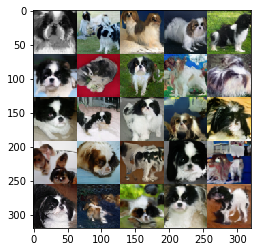

In [338]:
pyplot.imshow(((res.view(5,5,3,64,64).permute(0,3,1,4,2).reshape(5*64,5*64,3)*127.5+127.5).clamp(0,255).byte()).detach().numpy())

In [401]:
sd_dis, sd_gen = torch.load('./snapshot_80000.pt')

In [402]:
generator = ResNetGenerator(n_classes=1000)
generator.eval()
generator.load_state_dict(sd_gen)

In [403]:
with torch.no_grad():
    res = generator(batchsize=25)

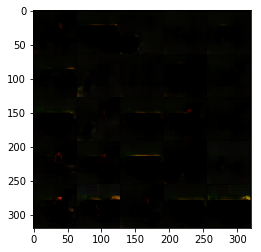

In [404]:
pyplot.imshow(((res.view(5,5,3,64,64).permute(0,3,1,4,2).reshape(5*64,5*64,3)*127.5+127.5).clamp(0,255).byte()).detach().numpy())

In [ ]:
pyplot.imshow(res[0].mean(0).numpy())

In [14]:
import torch

inputSize = 70
outputSize = 50
batchSize = 20

linear = torch.nn.Linear(inputSize, outputSize)
linear.cuda()

inp = torch.Tensor(range(batchSize*inputSize)).reshape(batchSize, inputSize).cuda()
torch.cuda.synchronize()
out1 = linear(inp)

lst = []
for i in range(batchSize):
    o = linear(inp[i:i+1])
    lst.append(o)
out2 = torch.cat(lst, 0)

print("diff=", (out1-out2).abs().max().item())


diff= 0.000244140625


In [77]:
for n,p in generator.named_parameters():
    parts = set(n.split('.'))
    if not ('b1' in parts or 'b2' in parts or 'b6' in parts or 'bias' in parts):
         print (n, '{:.3f},{:.3f}'.format(p.std(unbiased=False).item(), p.mean().item()))

l1.weight 0.011,-0.000
block2.c1.weight 0.017,-0.000
block2.c2.weight 0.021,-0.000
block2.c_sc.weight 0.036,-0.000
block3.c1.weight 0.024,-0.000
block3.c2.weight 0.029,-0.000
block3.c_sc.weight 0.051,-0.000
block4.c1.weight 0.034,-0.000
block4.c2.weight 0.042,0.000
block4.c_sc.weight 0.072,0.001
block5.c1.weight 0.048,0.000
block5.c2.weight 0.059,0.001
block5.c_sc.weight 0.103,0.002
l6.weight 0.058,0.000


tensor(0., device='cuda:0', grad_fn=<StdBackward0>)

In [9]:
import os, sys, time
import shutil
import yaml

import argparse
import chainer
from chainer import training
from chainer.training import extension
from chainer.training import extensions

PATH = '/home/tv/data/vision/other-sn-gan/sngan_projection/'
if PATH not in sys.path:
    sys.path.append(PATH)
from evaluation import sample_generate_conditional, sample_generate_light, calc_inception
import source.yaml_utils as yaml_utils




def load_models(config):
    gen_conf = config.models['generator']
    gen = yaml_utils.load_model(gen_conf['fn'], gen_conf['name'], gen_conf['args'])
    dis_conf = config.models['discriminator']
    dis = yaml_utils.load_model(dis_conf['fn'], dis_conf['name'], dis_conf['args'])
    return gen, dis


def make_optimizer(model, alpha=0.0002, beta1=0., beta2=0.9):
    optimizer = chainer.optimizers.Adam(alpha=alpha, beta1=beta1, beta2=beta2)
    optimizer.setup(model)
    return optimizer

class args:
    pass
args.config_path = '/home/tv/data/vision/other-sn-gan/sngan_projection/configs/sn_projection_dog_and_cat_64.yml'
args.gpu = 0 # gpu 0
args.data_dir = '/home/tv/data/vision/other-sn-gan/sngan_projection/datasets/preprocessed_cats_dogs/'
args.results_dir = '/home/tv/data/vision/other-sn-gan/sngan_projection/output/'
args.inception_model_path='/home/tv/data/vision/other-sn-gan/sngan_projection/datasets/inception_model'
#    parser.add_argument('--snapshot', type=str, default='',
#                        help='path to the snapshot')
args.loaderjob = 1

config = yaml_utils.Config(yaml.load(open(args.config_path)))

def replace_paths(d, root):
    for k,v in d.items():
        if isinstance(v, dict):
            replace_paths(v, root)
        if k in {'path', 'fn', 'dataset_fn'}:
            d[k] = os.path.join(root, d[k])

replace_paths(config.config, PATH)

chainer.cuda.get_device_from_id(args.gpu).use()


gen, dis = load_models(config)
gen.to_gpu(device=args.gpu)
dis.to_gpu(device=args.gpu)
models = {"gen": gen, "dis": dis}
# Optimizer
opt_gen = make_optimizer(
    gen, alpha=config.adam['alpha'], beta1=config.adam['beta1'], beta2=config.adam['beta2'])
opt_dis = make_optimizer(
    dis, alpha=config.adam['alpha'], beta1=config.adam['beta1'], beta2=config.adam['beta2'])
opts = {"opt_gen": opt_gen, "opt_dis": opt_dis}
# Dataset
config['dataset']['args']['root'] = args.data_dir
dataset = yaml_utils.load_dataset(config)


/usr/lib/python3/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [10]:
gen_state = {}
gen.serialize(chainer.serializers.DictionarySerializer(gen_state))
dis_state = {}
dis.serialize(chainer.serializers.DictionarySerializer(dis_state))

def rename_param(k):
    return ((k+'$').replace('/','.').replace('.beta','.bias').replace('.gamma','.weight')
                   .replace('.avg_mean','.running_mean').replace('.avg_var','.running_var')
                   .replace('.N$','.num_batches_tracked$').replace('.weights.W$','.weight$')
                   .replace('.biass.W$','.bias$').replace('.W$','.weight$').replace('.b$','.bias$')
                   .replace('.u$', '.weight_u$')[:-1].lstrip('.'))

def translate_sd(sd, target):
    sd2 = {rename_param(k):torch.from_numpy(v).clone() for k,v in sd.items()}
    sdo = target.state_dict()
    for k in [k for k in sdo.keys() if k.endswith('_orig')]:
        sd2[k] = sd2[k.replace('.weight_orig','.weight')]
    for k in [k for k in sdo.keys() if k.endswith('_u')]:
        sd2[k].squeeze_(0)
    return sd2

discriminator = SNResNetProjectionDiscriminator(n_classes=143)
generator = ResNetGenerator(n_classes=143)

dis_sd = translate_sd(dis_state, discriminator)
gen_sd = translate_sd(gen_state, generator)

discriminator.load_state_dict(dis_sd)
generator.load_state_dict(gen_sd)

opt_dis_pt = torch.optim.Adam(params=discriminator.parameters(), lr=init_lr, betas=(0.0, 0.9))
opt_gen_pt = torch.optim.Adam(params=generator.parameters(), lr=init_lr, betas=(0.0, 0.9))


In [11]:
import numpy
import math
imgs, labs = zip(*[dataset[i*1000] for i in range(32)])
imgs = numpy.stack(imgs, axis=0)
labs = numpy.array(labs)
imgs.shape, labs.shape

batch = gen.xp.array(imgs, dtype=numpy.float32),gen.xp.array(labs, dtype=numpy.int64)

/usr/lib/python3/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/lib/python3/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


In [12]:
from source.miscs.random_samples import sample_continuous, sample_categorical


def loss_hinge_dis(dis_fake, dis_real):
    loss = chainer.functions.mean(chainer.functions.relu(1. - dis_real))
    loss += chainer.functions.mean(chainer.functions.relu(1. + dis_fake))
    return loss


def loss_hinge_gen(dis_fake):
    loss = -chainer.functions.mean(dis_fake)
    return loss


n_gen_samples = 32
xp = gen.xp
DEBUG_CHAINER_GEN={}
DEBUG_CHAINER_DIS={}
for i in range(1):
    if i == 0:
        y_fake = sample_categorical(gen.n_classes, n_gen_samples, xp=gen.xp)
        z_fake = sample_continuous(gen.dim_z, n_gen_samples, distribution=gen.distribution, xp=gen.xp)
        x_fake = gen(n_gen_samples, y=y_fake, z=z_fake, DEBUG=DEBUG_CHAINER_GEN)
        x_fake_dis = chainer.Variable(x_fake.data, requires_grad=True)
        dis_fake = dis(x_fake_dis, y=y_fake)
        loss_gen = loss_hinge_gen(dis_fake=dis_fake)
        gen.cleargrads()
        loss_gen.backward(retain_grad=True)
        chainer.functions.sum(x_fake*x_fake_dis.grad).backward()
        opt_gen.update()        
        print({'loss_gen': loss_gen})
    x_real, y_real = batch
    batchsize = len(x_real)
    dis_real = dis(x_real, y=y_real)
    y_fake_dis = sample_categorical(gen.n_classes, n_gen_samples, xp=gen.xp)
    z_fake_dis = sample_continuous(gen.dim_z, n_gen_samples, distribution=gen.distribution, xp=gen.xp)
    x_fake_dis = gen(n_gen_samples, y=y_fake_dis, z=z_fake_dis)
    dis_fake = dis(x_fake_dis, y=y_fake_dis, DEBUG=DEBUG_CHAINER_DIS)
    x_fake_dis.unchain_backward()

    loss_dis = loss_hinge_dis(dis_fake=dis_fake, dis_real=dis_real)
    dis.cleargrads()
    loss_dis.backward()
    opt_dis.update()
    print({'loss_dis': loss_dis})


{'loss_gen': variable(0.0327008)}
{'loss_dis': variable(2.0276747)}


In [13]:
import cupy
DEBUG_PYTORCH_GEN = {}
DEBUG_PYTORCH_DIS = {}
y_fake_pt = torch.from_numpy(cupy.asnumpy(y_fake)).long()
z_fake_pt = torch.from_numpy(cupy.asnumpy(z_fake))
x_fake_pt = generator(batchsize=n_gen_samples, z=z_fake_pt, y=y_fake_pt, DEBUG=DEBUG_PYTORCH_GEN)
x_fake_pt.retain_grad()
dis_fake_pt = discriminator(x_fake_pt, y=y_fake_pt)
loss_gen_pt = -dis_fake_pt.mean()
generator.zero_grad()
loss_gen_pt.backward()
opt_gen_pt.step()
print({'loss_gen': loss_gen_pt.item()})


x_real_pt = torch.from_numpy(cupy.asnumpy(x_real))
y_real_pt = torch.from_numpy(cupy.asnumpy(y_real)).long()
#        x_real = x_real.to(device)
#        y_real = y_real.to(device)
bs = len(x_real)
dis_real_pt = discriminator(x_real_pt, y=y_real_pt)
with torch.no_grad():
    y_fake_dis_pt = torch.from_numpy(cupy.asnumpy(y_fake_dis)).long()
    z_fake_dis_pt = torch.from_numpy(cupy.asnumpy(z_fake_dis))

    #y_fake = torch.randint(0, generator.n_classes, (bs,), device=device, dtype=torch.long)
    x_fake_dis_pt = generator(bs, y=y_fake_dis_pt, z=z_fake_dis_pt).detach()

dis_fake_pt = discriminator(x_fake_dis_pt, y=y_fake_dis_pt, DEBUG=DEBUG_PYTORCH_DIS)

loss_dis_pt = (torch.nn.functional.relu(1. - dis_real_pt).mean() +
                    torch.nn.functional.relu(1. + dis_fake_pt).mean())
opt_dis_pt.zero_grad()
loss_dis_pt.backward()
opt_dis_pt.step()
print ({'loss_dis':loss_dis_pt.item()})

{'loss_gen': 0.032700832933187485}
{'loss_dis': 2.0273492336273193}


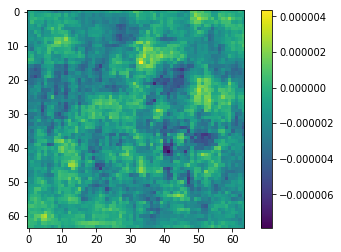

In [14]:
#x_fake_dis.grad
pyplot.imshow(x_fake_pt.grad[0,0].detach().numpy())
pyplot.colorbar()
#DEBUG_CHAINER_GEN['generator.z']-DEBUG_PYTORCH_GEN['generator.z'].numpy()

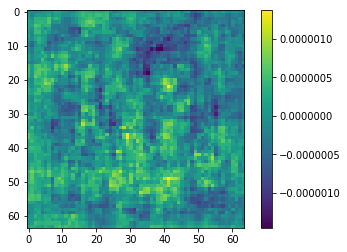

In [15]:
pyplot.imshow(cupy.asnumpy(x_fake_dis.grad[0,0]))
pyplot.colorbar()

(array([3.3487e+04, 3.3344e+04, 3.2295e+04, 3.1375e+04, 2.9803e+04,
        2.8210e+04, 2.6105e+04, 2.4066e+04, 2.1730e+04, 1.9626e+04,
        1.7612e+04, 1.5491e+04, 1.3209e+04, 1.1382e+04, 1.0156e+04,
        8.5670e+03, 6.9900e+03, 5.9430e+03, 4.7970e+03, 3.8470e+03,
        3.1390e+03, 2.6010e+03, 2.0350e+03, 1.6290e+03, 1.2810e+03,
        1.0700e+03, 7.7400e+02, 5.8500e+02, 5.3600e+02, 3.5800e+02,
        3.0100e+02, 2.2100e+02, 1.4300e+02, 1.3000e+02, 1.0100e+02,
        7.9000e+01, 5.2000e+01, 4.5000e+01, 3.2000e+01, 1.5000e+01,
        2.0000e+01, 8.0000e+00, 1.0000e+01, 5.0000e+00, 2.0000e+00,
        3.0000e+00, 0.0000e+00, 3.0000e+00, 0.0000e+00, 3.0000e+00]),
 array([4.12114787e-13, 1.93206328e-07, 3.86412244e-07, 5.79618159e-07,
        7.72824075e-07, 9.66029991e-07, 1.15923591e-06, 1.35244182e-06,
        1.54564774e-06, 1.73885365e-06, 1.93205957e-06, 2.12526549e-06,
        2.31847140e-06, 2.51167732e-06, 2.70488323e-06, 2.89808915e-06,
        3.09129506e-06, 3.2845

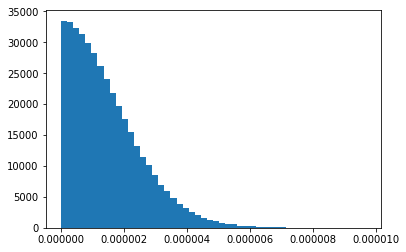

In [16]:
pyplot.hist(numpy.abs((x_fake_pt.grad.detach().numpy()-cupy.asnumpy(x_fake_dis.grad))).flatten(),bins=50)

In [17]:
(generator.l1.weight.grad-torch.from_numpy(cupy.asnumpy(gen.l1.W.grad))).abs().max()

tensor(0.0004)

In [18]:
#d1={rename_param(n):torch.from_numpy(cupy.asnumpy(p.grad)) for n,p in gen.namedparams()}
#d2={n:p.grad for n,p in generator.named_parameters()}
d1={rename_param(n):torch.from_numpy(cupy.asnumpy(p.data)) for n,p in gen.namedparams()}
d2={n:p.detach() for n,p in generator.named_parameters()}
d1_dis={rename_param(n):torch.from_numpy(cupy.asnumpy(p.grad)) for n,p in dis.namedparams()}
d2_dis={n.replace("_orig",""):p.grad.detach() for n,p in discriminator.named_parameters()}


In [30]:
if 0:
    for k in d2.keys():
        print (k, (d1[k]-d2[k]).abs().max().item())
for k in d2_dis.keys():
    print (k, ((d1_dis[k]-d2_dis[k])).abs().max().item())


block1.c1.bias 0.0007791388779878616
block1.c1.weight 0.0006775555666536093
block1.c2.bias 0.0013547074049711227
block1.c2.weight 0.0002794871979858726
block1.c_sc.bias 0.0013547074049711227
block1.c_sc.weight 0.001232558162882924
block2.c1.bias 0.0015672128647565842
block2.c1.weight 0.00026404252275824547
block2.c2.bias 0.0024119168519973755
block2.c2.weight 0.00024983170442283154
block2.c_sc.bias 0.0024119168519973755
block2.c_sc.weight 0.00042765564285218716
block3.c1.bias 0.003420155495405197
block3.c1.weight 0.00033381395041942596
block3.c2.bias 0.0035283993929624557
block3.c2.weight 0.0002638082951307297
block3.c_sc.bias 0.0035283993929624557
block3.c_sc.weight 0.00039308564737439156
block4.c1.bias 0.003069249913096428
block4.c1.weight 0.00036834320053458214
block4.c2.bias 0.005206878297030926
block4.c2.weight 0.00024273386225104332
block4.c_sc.bias 0.005206878297030926
block4.c_sc.weight 0.0003629347775131464
block5.c1.bias 0.004149998538196087
block5.c1.weight 0.000256834435276

In [294]:
w1 = torch.from_numpy(cupy.asnumpy(dis.block1.c1.W.data))
w1p = discriminator.block1.c1.weight_orig

In [297]:
discriminator.l_y.weight.grad

In [302]:
discriminator.l_y.weight_orig

Parameter containing:
tensor([[-0.0609,  0.0047, -0.0527,  ...,  0.0266, -0.0586, -0.0585],
        [ 0.0316,  0.0538,  0.0594,  ...,  0.0176,  0.0557, -0.0297],
        [ 0.0340, -0.0482,  0.0441,  ..., -0.0511, -0.0395,  0.0480],
        ...,
        [ 0.0555, -0.0500,  0.0130,  ...,  0.0271, -0.0242,  0.0649],
        [-0.0039,  0.0191,  0.0384,  ..., -0.0446,  0.0346,  0.0069],
        [ 0.0207,  0.0595,  0.0058,  ..., -0.0051,  0.0692, -0.0268]],
       requires_grad=True)

In [304]:
dis.l_y.W.grad

array([[-1.21666773e-07, -1.55477142e-06,  2.75258299e-06, ...,
        -1.11887368e-06, -3.99904678e-07, -2.05176798e-06],
       [-4.66111402e-07, -6.37804260e-06,  1.13380202e-05, ...,
        -4.61741001e-06, -1.63507707e-06, -8.38596770e-06],
       [-2.45945813e-07,  3.37552134e-04,  1.86965117e-04, ...,
         5.09122328e-04,  1.20224526e-04, -5.13478244e-06],
       ...,
       [-2.38444898e-07, -1.54652080e-04, -2.45209294e-03, ...,
        -1.20616937e-03, -8.77308878e-07, -4.49840854e-06],
       [-3.07902575e-08,  4.42194985e-04,  1.40629549e-04, ...,
         5.16218017e-04,  1.36921872e-05, -9.38616381e-07],
       [ 7.07746750e-10,  1.40232288e-07, -2.62664599e-07, ...,
         1.09480219e-07,  3.43806832e-08,  1.75452996e-07]], dtype=float32)

In [231]:
"""cuda.elementwise(
                'T grad, T lr, T one_minus_beta1, T one_minus_beta2, T eps, \
                 T eta, T weight_decay_rate',
                'T param, T m, T v',
                '''m += one_minus_beta1 * (grad - m);
                   v += one_minus_beta2 * (grad * grad - v);
                   param -= eta * (lr * m / (sqrt(v) + eps) +
                                   weight_decay_rate * param);''',
                'adam')(grad, self.lr, 1 - hp.beta1,
                        1 - hp.beta2, hp.eps,
                        hp.eta, hp.weight_decay_rate,
                        param.data, self.state['m'], self.state['v'])
"""
opt_gen.t

3

In [233]:
(gen_sd['l1.weight']-generator.l1.weight).detach()*1e4

tensor([[-1.9993, -1.9817,  1.9994,  ..., -1.9981, -1.9995,  1.9985],
        [ 1.9988, -1.9993, -1.9945,  ...,  1.9971, -1.9986,  1.9993],
        [ 1.9995,  1.9963, -1.9994,  ..., -1.9858,  1.9997, -1.9998],
        ...,
        [ 1.9990, -1.9996, -1.9996,  ...,  1.9998,  1.9995, -1.9988],
        [-1.9997, -1.9995, -1.9981,  ...,  1.9996, -1.9994,  1.9974],
        [-1.9971,  1.9996, -1.9974,  ...,  1.9993, -1.9990,  1.9981]])

In [234]:
d1['l1.weight']-gen_sd['l1.weight']

tensor([[ 8.9767e-05, -3.9523e-05, -5.5865e-05,  ...,  1.4618e-04,
          9.0046e-05, -4.2478e-05],
        [-2.8712e-04,  1.1143e-04, -9.5926e-07,  ...,  2.2854e-05,
          1.2320e-04, -2.3707e-04],
        [-1.0593e-04, -2.7025e-04,  5.0901e-05,  ...,  5.2853e-06,
         -2.2207e-04,  2.7944e-04],
        ...,
        [-5.8498e-05,  2.2891e-04,  1.9101e-04,  ..., -2.3433e-04,
         -2.0764e-04,  4.6424e-05],
        [ 3.0076e-04,  1.3821e-04,  6.0045e-05,  ..., -1.6438e-04,
          2.3528e-04, -1.0314e-04],
        [ 3.7167e-05, -2.3817e-04,  2.9986e-05,  ..., -6.4427e-05,
          2.3743e-04, -2.2781e-05]])

In [246]:
opt_gen.t

1

In [247]:
torch.from_numpy(cupy.asnumpy(gen.l1.W.data))-d1['l1.weight']

tensor([[-0.0070,  0.0041, -0.0149,  ...,  0.0065,  0.0005, -0.0021],
        [-0.0011,  0.0221,  0.0254,  ..., -0.0001,  0.0219, -0.0070],
        [-0.0190, -0.0059,  0.0034,  ...,  0.0252,  0.0122, -0.0133],
        ...,
        [ 0.0265,  0.0131,  0.0068,  ..., -0.0262,  0.0065, -0.0002],
        [-0.0049, -0.0202,  0.0136,  ..., -0.0203, -0.0221, -0.0061],
        [ 0.0115,  0.0043, -0.0049,  ..., -0.0329, -0.0094, -0.0147]])

In [248]:
generator.l1.weight-d1['l1.weight']

tensor([[-0.0070,  0.0041, -0.0149,  ...,  0.0065,  0.0005, -0.0025],
        [-0.0011,  0.0221,  0.0254,  ..., -0.0001,  0.0219, -0.0070],
        [-0.0190, -0.0055,  0.0034,  ...,  0.0252,  0.0122, -0.0133],
        ...,
        [ 0.0265,  0.0131,  0.0068,  ..., -0.0262,  0.0065, -0.0002],
        [-0.0049, -0.0202,  0.0136,  ..., -0.0203, -0.0221, -0.0061],
        [ 0.0115,  0.0043, -0.0049,  ..., -0.0325, -0.0094, -0.0147]],
       grad_fn=<ThSubBackward>)

In [259]:
generator.l1.weight[1,2], torch.from_numpy(cupy.asnumpy(gen.l1.W.data))[2,1]

(tensor(0.0188, grad_fn=<SelectBackward>), tensor(-0.0134))

In [276]:
opt_gen_pt.state_dict()['state'][hash(generator.l1.weight)]['exp_avg'][2,1],opt_gen_pt.state_dict()['state'][hash(generator.l1.weight)]['exp_avg_sq'][2,1]

(tensor(-0.0000), tensor(5.3151e-11))